# Analysis of aviation data

The `aviation data.csv` file contains monthly passengers, bookings, and revenue-passenger-
kilometers data for various combinations of source and destination regions for airplane flights. The main metric of interest is revenue-passenger-kilometers (RPK), a standard industry metric that measures the total distance travelled by all paying customers who fly the route within the month, as a proxy for total flight traffic. For any given month, assume that we are able to obtain data on the number of bookings well in advance of the realized RPK numbers.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import requests
import plotly.express as px

warnings.simplefilter('ignore')
plt.style.use('seaborn')

In [2]:
df = pd.read_csv('data/task3/aviation_data.csv', index_col='month', parse_dates=True).sort_index()
df

,source_region,destination_region,passengers,bookings,rpk
month,,,,,
2012-01-01,Asia : South East Asia,North America,205038,179329,2.647822e+09
2012-01-01,Latin America : Caribbean,Latin America : Caribbean,642030,106815,2.490826e+08
2012-01-01,Africa : Southern Africa,Europe : Western Europe,181433,119017,1.639930e+09
2012-01-01,Latin America : Upper South America,Southwest Pacific,1133,2036,1.732281e+07
2012-01-01,North America,Latin America : Upper South America,285405,170827,1.112488e+09
...,...,...,...,...,...
2020-12-01,Asia : North East Asia,Latin America : Caribbean,0,38,NaN
2020-12-01,Asia : North East Asia,Europe : Western Europe,0,10078,NaN
2020-12-01,Asia : North East Asia,Europe : Eastern/Central Europe,0,1882,NaN


## Part (a)

i) Restricting the data set to end on Dec 2019, aggregate over all source and destination regions to compute the monthly global bookings and RPK figures.

In [3]:
end_date = pd.to_datetime('2019-12-31')
df = df[df.index <= end_date]

# Group by month and get aggregate RPK figures
monthly_stats = df[['bookings', 'rpk']].groupby(df.index).sum()
monthly_stats

,bookings,rpk
month,,
2012-01-01,50881426,3.998870e+11
2012-02-01,49548460,3.671093e+11
2012-03-01,56332098,4.108986e+11
2012-04-01,56828511,4.095384e+11
2012-05-01,58560556,4.219209e+11
...,...,...
2019-08-01,77714489,7.483558e+11
2019-09-01,72251873,6.877546e+11
2019-10-01,73144569,6.622085e+11


<AxesSubplot:title={'center':'Monthly RPK'}, xlabel='month'>

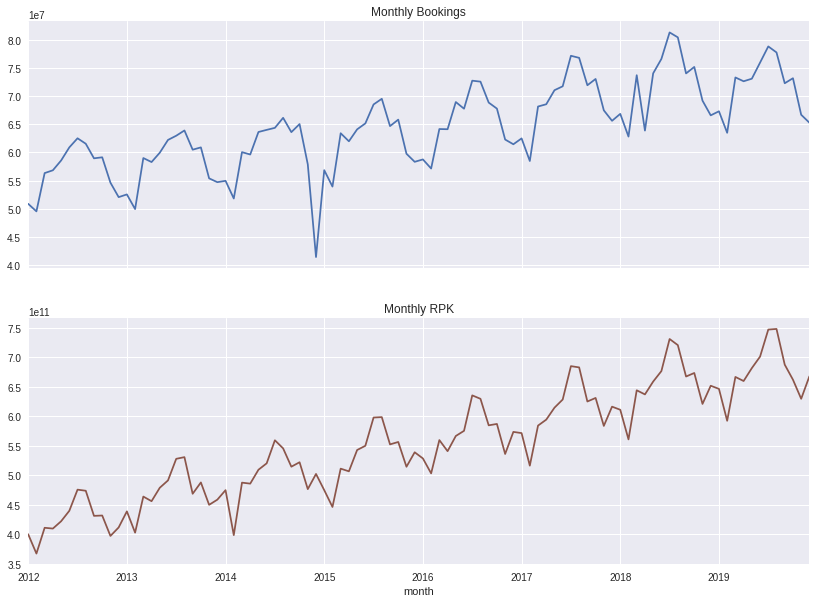

In [4]:
# The plots show clear seasonality
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
monthly_stats['bookings'].plot(title='Monthly Bookings', ax=axes[0])
monthly_stats['rpk'].plot(title='Monthly RPK', ax=axes[1], color='tab:brown')

ii) Then, letting $x_t$ and $y_t$ denote bookings and RPK in time period t respectively, write a function that:
- takes as inputs the data frame that stores the global figures, and a non-negative integer parameter $d$;

- uses as the independent and dependent variables $x_t$ and $y_t$ in levels respectively if $d=0$, or $\hat{x}_t = \frac{x_t - x_{t-d}}{x_{t-d}}$ and $\hat{y}_t = \frac{y_t - y_{t-d}}{y_{t-d}}$ in percent changes if $d \geq 1$; 

- fits a simple linear model involving the appropriate variables, using Ordinary Least Squares (OLS) on data in a moving 36-month window; and 

- creates and stores the next-month forecast of RPK, denoted $\hat{y}_{t+1}$, along with the forecast percent error $\hat{e}_{t+1} = \frac{\hat{y}_{t+1} - y_{t+1}}{y_{t+1}}$.

Your output should be a data frame with the computed forecasts and percent errors for each month after first 36 months.

### Code implementation and answer

`RollingOLS` applies `OLS` across a fixed window of observations (36 months) and then rolls the window across the data set.

In [5]:
def rolling_window_forecast(df, d: int, inc_const=False):
    monthly_stats = df.copy()
    if d >= 1:
        dataframe = monthly_stats.pct_change(d).dropna()  # lose first d rows
    else:
        dataframe = monthly_stats.copy()

    endog = dataframe['rpk']
    if inc_const:
        exog = sm.add_constant(dataframe['bookings'])
    else:
        exog = dataframe['bookings']
    
    # Perform rolling regression with 36-month window
    rols = RollingOLS(endog, exog, window=36)
    rres = rols.fit()
    coeffs = rres.params
    
    if inc_const:
        rpk_change_forecast = coeffs['const'].shift(1) + coeffs['bookings'].shift(1) * dataframe['bookings']
    else:
        rpk_change_forecast = coeffs['bookings'].shift(1) * dataframe['bookings']
    
    # it is a percentage change d-periods behind, so need to shift and then multiply
    monthly_stats['rpk_forecast'] = monthly_stats['rpk'].shift(d) * (rpk_change_forecast + 1)
    monthly_stats['forecast_err'] = (monthly_stats['rpk_forecast'] - monthly_stats['rpk']) / monthly_stats['rpk']
    return monthly_stats.dropna()

## Part (b)

Run your function for $d = 0$ to obtain forecasts from a model in *levels*.

- Visualize your forecast of RPK together with the actual figures, and also create a plot of the forecast errors $\hat{e}_{t+1}$.

- Comment on the forecast errors and any violation of OLS assumptions that might be responsible.

### Code implementation

In [6]:
level_forecast = rolling_window_forecast(monthly_stats, d=0, inc_const=True)
level_forecast.head(10)

,bookings,rpk,rpk_forecast,forecast_err
month,,,,
2015-01-01,56847662,4.747605e+11,2.168083e+23,4.566688e+11
2015-02-01,53940076,4.462216e+11,1.970835e+23,4.416717e+11
2015-03-01,63395570,5.112417e+11,2.525455e+23,4.939845e+11
2015-04-01,61967098,5.066785e+11,2.474345e+23,4.883462e+11
2015-05-01,64082925,5.428604e+11,2.718798e+23,5.008281e+11
2015-06-01,65135430,5.500392e+11,2.805150e+23,5.099909e+11
2015-07-01,68496277,5.979850e+11,3.188673e+23,5.332363e+11
2015-08-01,69500052,5.986924e+11,3.280150e+23,5.478857e+11
2015-09-01,64656314,5.524144e+11,2.885497e+23,5.223429e+11


### Final answers

First I visualize the forecast of RPK together with the actual figures for $d=0$. The forecasts are orders of magnitude higher than the realized values.

<AxesSubplot:title={'center':'Forecast Error (d = 0)'}, xlabel='month'>

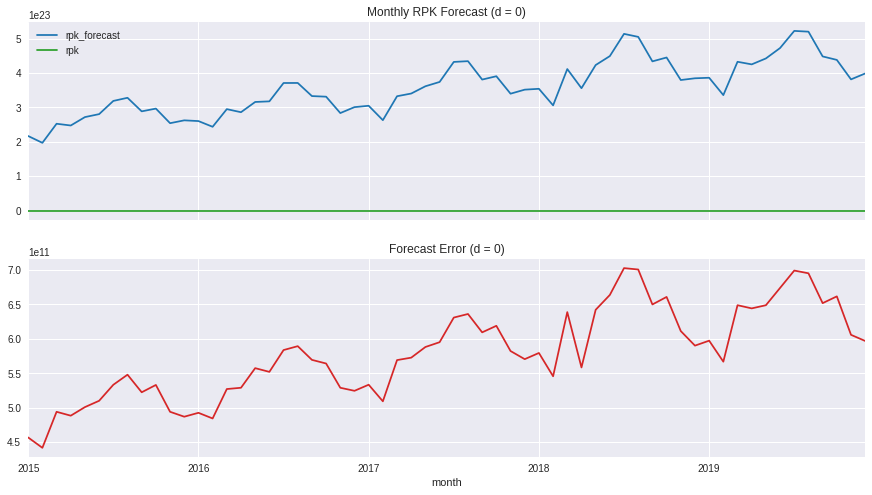

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

level_forecast[['rpk_forecast', 'rpk']].plot(
    title='Monthly RPK Forecast (d = 0)', ax=axes[0], color=['tab:blue', 'tab:green'])

level_forecast['forecast_err'].plot(title='Forecast Error (d = 0)', ax=axes[1], color='tab:red')

The residuals (or errors) are assumed to be independent and identically distributed (iid) normal random variables with mean zero, i.e. Gaussian white noise. This is clearly not the case here - the errors exhibit a strong seasonal trend, which implies that the model does not adaquately capture these effects. A high level of *autocorrelation* can be observed in the errors. 

The seasonal effects violate the assumption of *stationarity*. In essence, the conditional mean and variance are not constant. This is resolved in the next part of the task. Differencing the data, or taking percent changes, can eliminate trend and seasonality and produce a stationary time series.

## Part (c)

Now, run your function for $d = 1$ to obtain forecasts from a model in changes.

i) Visualize your forecast of RPK together with the actual figures, and also create a plot of the forecast errors $\hat{e}_{t+1}$.

ii) Check for autocorrelation in the above forecast errors, diagnose any modelling issues, and refit a model with a suitable value of $d$. Plot and check the forecast errors of the refitted model.

iii) If needed, further refine your model by considering autoregressive (i.e. lagged) terms where appropriate. Guide your model selection with diagnostic plots, statistical tests, and metrics such as the mean absolute percent error

\begin{equation}
    \text{MAPE} = \frac{1}{\mathcal{T}} \sum_{t\subseteq \mathcal{T}} |\hat{e}_{t+1}|
\end{equation}

where $T$ is the out-of-sample set (i.e. test set) of months that should be common across all models being evaluated, and $|\mathcal{T}|$ is the size of this set.

### Diagnosing initial model

<AxesSubplot:title={'center':'Forecast Error (d = 1)'}, xlabel='month'>

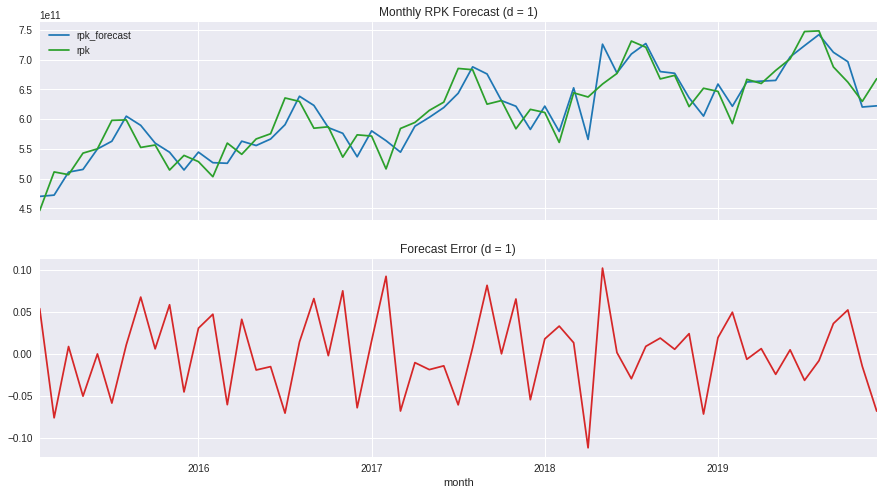

In [8]:
forecast = rolling_window_forecast(monthly_stats, d=1, inc_const=True)

fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

forecast[['rpk_forecast', 'rpk']].plot(
    title='Monthly RPK Forecast (d = 1)', ax=axes[0], color=['tab:blue', 'tab:green'])

forecast['forecast_err'].plot(title='Forecast Error (d = 1)', ax=axes[1], color='tab:red')

The fit already looks much better. Now I create an ACF plot, and use the Ljung-Box test to check for serial correlation in the residuals:

> $H_0$: The data are independently distributed

> $H_a$: The data are not independently distributed; they exhibit serial correlation.

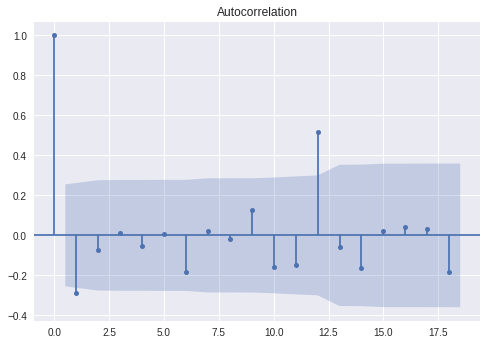

,lb_stat,lb_pvalue
1,5.213452,0.022413
2,5.540402,0.062649
3,5.547378,0.135832
4,5.744825,0.219033
5,5.749201,0.331393
6,8.033640,0.235649
7,8.063012,0.327070
8,8.092705,0.424467
9,9.256280,0.413962
10,11.108353,0.349139


In [9]:
plot_acf(forecast['forecast_err'])
plt.show()
acorr_ljungbox(forecast['forecast_err'], lags=13, return_df=True)

And now further refining the model, utilizing $d=11$:

<AxesSubplot:title={'center':'Forecast Error (d = 1)'}, xlabel='month'>

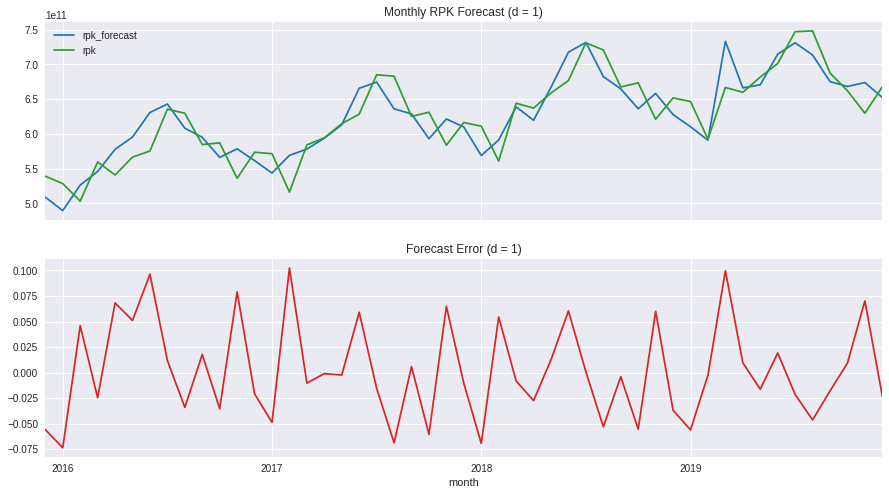

In [10]:
forecast_11 = rolling_window_forecast(monthly_stats, d=11, inc_const=True)

fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

forecast_11[['rpk_forecast', 'rpk']].plot(
    title='Monthly RPK Forecast (d = 1)', ax=axes[0], color=['tab:blue', 'tab:green'])

forecast_11['forecast_err'].plot(title='Forecast Error (d = 1)', ax=axes[1], color='tab:red')

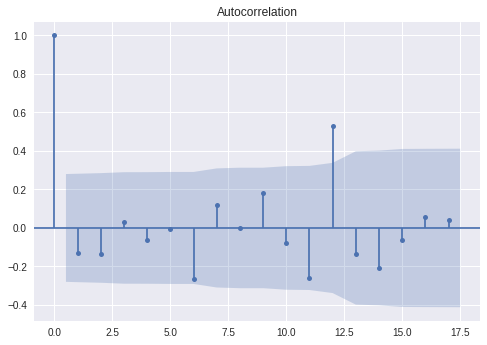

In [11]:
plot_acf(forecast_11['forecast_err'])
plt.show()

### Implementing a SARIMA Model

The effect of seasonality can be modeled using a 'seasonal' ARIMA model. The model takes the form $\text{SARIMA}(p,d,q)(P,D,Q)_m$, where $(p,d,q)$ are the various parameters for the *non-seasonal ARIMA* model, and $(P,D,Q)$ can be seen as the *seasonal portion*. 

To fit the SARIMA model, I use a statistical library, `pmdarima`, which provides the equivalent of R's `auto.arima` functionality. It also includes a variety of tools that aid in exploratory data analysis. Below, I utilise the `tsdisplay` function to show the data plot, ACF plot and a distributional bar plot.

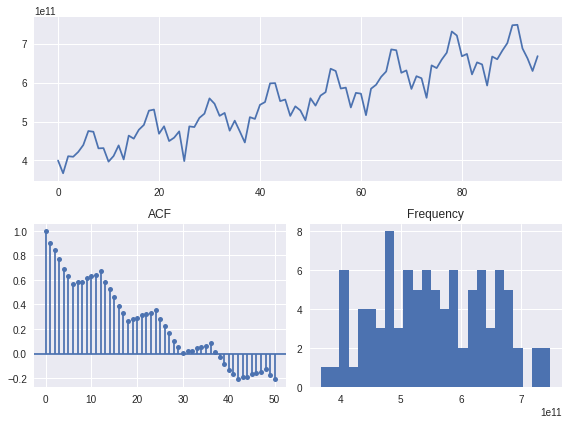

In [12]:
import pmdarima as pmd
from pmdarima import arima

pmd.tsdisplay(monthly_stats['rpk'])

As suspected, there is a high degree of serial-correlaiton. We can also use pmdarima's suite of statistical test tools. Below, I perform an augmented Dickey-Fuller (ADF) test, which tests the null hypothesis of the presence of a unit root in a time series sample. Rejection of the null hypothesis implies stationarity.

In [13]:
adf_test = arima.ADFTest(alpha=0.05)  # use the 5% confidence level
adf_test.should_diff(monthly_stats['rpk'].values)

(0.01, False)

The null hypothesis cannot be rejected. Instead of manually differencing the data, the `auto_arima` function can search for the optimal order of integration (differencing) and lag values. It performs this by maximimising the log-likelihood and minimizing an information criterion of choice. I use the AIC here, which penalizes a higher number of parameters for the sake of a parsimonious model.

In [14]:
model = pmd.auto_arima(
    y=monthly_stats['rpk'].values.reshape((-1, 1)),
    exogenous=monthly_stats['bookings'].values.reshape((-1, 1)),
    start_p=1,
    start_q=1,
    max_p=5,
    max_q=5,
    m=12, # seasonal differencing, 12 for monthly data
    seasonal=True,
    stationary=False,  # not stationary
    information_criterion='aic', # akaike information criterion
    suppress_warnings=True)

model

ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(0, 0, 2, 12),
      suppress_warnings=True)

Now, to compare this model with the ones defined before, we perform the same process of sliding window forecasts. The function below dynamically changes lag orders by fitting the data points that are within the 36-month window. Then, it performs a 1-month ahead forecast/ prediction.

In [15]:
def auto_arima_forecasts(df):
    bookings, rpk = df['bookings'], df['rpk']
    forecast_dates, forecast_rpk = [], []
    
    for t in range(0, len(df)-36):
        
        y = rpk.values[t:t+36].reshape((-1, 1))
        x = bookings.values[t:t+36].reshape((-1, 1))
        forecast_dates.append(bookings.index[t+36])
        forecast_x = bookings.values[t+36].reshape((-1, 1))
        
        model = pmd.auto_arima(y, x, start_p=1, start_q=1, max_p=5, max_q=5, m=12,
                               seasonal=True, stationary=False,
                               information_criterion='aic',
                               suppress_warnings=True)
                
        forecast_rpk.append(model.predict(1, forecast_x)[0])
    result = pd.DataFrame({'date': forecast_dates, 'rpk_forecast': forecast_rpk}).set_index('date')
    result = pd.concat([bookings, rpk, result], axis=1)
    result['forecast_err'] = (result['rpk'] - result['rpk_forecast']) / result['rpk']
    return result

sarima_forecasts = auto_arima_forecasts(monthly_stats)

<AxesSubplot:title={'center':'Forecast Error'}>

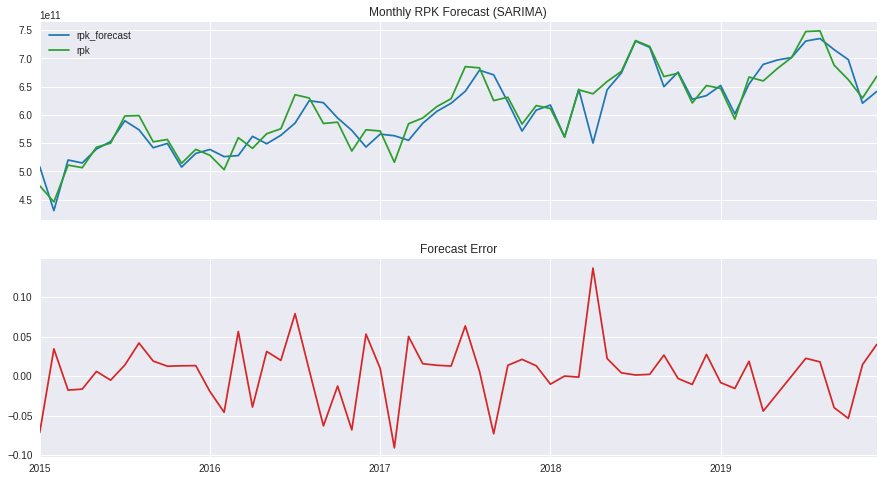

In [16]:
sarima_forecasts.dropna(inplace=True)
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

sarima_forecasts[['rpk_forecast', 'rpk']].plot(
    title='Monthly RPK Forecast (SARIMA)', ax=axes[0], color=['tab:blue', 'tab:green'])

sarima_forecasts['forecast_err'].plot(title='Forecast Error', ax=axes[1], color='tab:red')

Now I compare the results for each models:

1. OLS model with $d=0$
2. OLS model with $d=1$
3. OLS model with $d=11$
4. SARIMA model

In [17]:
mape_1 = level_forecast['forecast_err'].abs().mean()
mape_2 = forecast['forecast_err'].abs().mean()
mape_3 = forecast_11['forecast_err'].abs().mean()
mape_4 = sarima_forecasts['forecast_err'].abs().mean()

In [18]:
performance_summary = pd.DataFrame(
    {'Model': ['OLS (d=0)', 'OLS (d=1)', 'OLS (d=11)', 'SARIMA'],
     'MAPE': [mape_1, mape_2, mape_3, mape_4]}).set_index('Model')

performance_summary.sort_values(by='MAPE')

,MAPE
Model,
SARIMA,2.811060e-02
OLS (d=1),3.702962e-02
OLS (d=11),3.875092e-02
OLS (d=0),5.793330e+11


## Part (d)

The data set contains data for three months into Covid-19: Jan, Feb, and Mar 2020.

i) Condensing source and destination regions in a sensible manner, create appropriate visualizations to show the impact of Covid-19 on flights coming out of and going into the various regions.

ii) Briefly discuss your findings, and whether your final model from part (c) could have accurately forecasted the dip in global RPK.

In [19]:
full_df = pd.read_csv('data/task3/aviation_data.csv', index_col='month', parse_dates=True).sort_index()

I will plot data from 2018-03-31 to 2020-03-31 to show the year-on-year difference:

In [20]:
start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2020-03-31')

data = full_df[(full_df.index >= start_date) & (full_df.index <= end_date)]

In [21]:
res = requests.get('https://gist.githubusercontent.com/cmunns/76fb72646a68202e6bde/raw/8f954b3ca01835bee4af9ae50dfe73eb6ab88fca/continents.json')
geojson = res.json()

print([i['properties'] for i in geojson['features']])

[{'continent': 'asia'}, {'continent': 'africa'}, {'continent': 'europe'}, {'continent': 'northAmerica'}, {'continent': 'oceania'}, {'continent': 'southAmerica'}]


In [22]:
geojson['features'][0]['properties']

{'continent': 'asia'}

In [23]:
data['continent'] = data['source_region'].apply(lambda x: x.split(' : ')[0].lower())
data['continent'] = data['continent'].apply(
    lambda x: 'northAmerica' if x == 'north america' else (
        'oceania' if x == 'southwest pacific' else (
            'southAmerica' if x == 'latin america' else x)))
data = data.groupby(['month', 'continent']).sum()
data['timeframe'] = data.index.get_level_values(0).strftime('%Y-%m-%d')
data.reset_index(inplace=True)

In [ ]:
# Run this cell for interactive map
from IPython.display import IFrame

"""
fig = px.choropleth(data, geojson=geojson,
                    locations="continent",
                    color="passengers",
                    color_continuous_scale="Viridis",
                    range_color=(data['passengers'].min(), data['passengers'].max()),
                    hover_name="continent",
                    animation_frame="timeframe",
                    featureidkey="properties.continent")

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html("aviation_map.html")
"""

IFrame(src='aviation_map.html', width=700, height=700)

Using the above forecasting models is relatively accurate on the whole, with the dynamic SARIMA model displaying a mean absolute perecent error of approximately 2.8%. One might argue that higher-resolution data would improve the forecasting accuracy of the model.

However, t is clear that in all of the models tested in this notebook, large errors occur when there are large shocks. ARMA models are more performant than OLS in serially-correlated time series as it regresses on lagged values and errors. In other words, it models the *conditional mean*.

One crucial assumption made in ARMA is that the conditional *variance* is constant. However, as often seen in time series processes, this process appears to be conditionally heteroscedastic. Therefore, during highly volatile periods (such as Covid-19), a GARCH model would need to be implemented to model the conditional variance. In a typical use-case, ARMA-GARCH models can be fitted simultaneously using Quasi-Maximum Likelihood Estimation. The forecasted conditional variance can then be used to estimate confidence intervals.